In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)

Now let's simulate an event with given shower parameters.

In [3]:
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-25.7,0,70]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=500.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-25.7, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

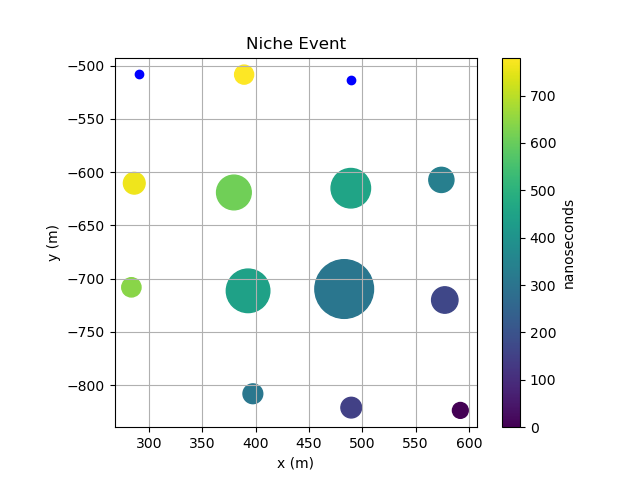

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
guess = make_guess(ty, pf)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=300.0, limits=(300.0, 600.0), error=50.0)
FitParam(name='nmax', value=100000.0, limits=(100000.0, 10000000.0), error=100000.0)
FitParam(name='zenith', value=0.7538985593657599, limits=(0.6538985593657599, 0.8538985593657599), error=0.017453292519943295)
FitParam(name='azimuth', value=5.466945237755093, limits=(5.366945237755093, 5.5669452377550925), error=0.017453292519943295)
FitParam(name='corex', value=447.71215263840077, limits=(379.5, 489.2), error=5.0)
FitParam(name='corey', value=-678.4380049093613, limits=(-711.4, -615.1), error=5.0)
FitParam(name='corez', value=-25.7, limits=(-26.684068710108292, -24.684068710108292), error=1.0)
FitParam(name='x0', value=0.0, limits=(-100, 100), error=1)
FitParam(name='lambda', value=70.0, limits=(0, 100), error=1)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [6]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

In [7]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.tol = .1
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 50.86 (χ²/ndof = 5.1)      │              Nfcn = 33               │
│ EDM = 0.18 (Goal: 0.1)           │            time = 9.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │    300    │    50     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax    │   0.1e6   │   0.1e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith  │  0.6982   │  0.0024   │            │            │0.653899 │0.853899 │       │
│ 3 │ azimuth │  5.5027   │  0.0009   │            │            │ 5.36695 │ 5.56695 │       │
│ 4 │ corex   │    448    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey   │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
tpguess = update_guess(m)
pw = PulseWidth(real_nfits, BasicParams, cfg)
pw.target_parameters = ['xmax']
m = init_minuit(pw, tpguess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 55.67 (χ²/ndof = 5.1)      │              Nfcn = 17               │
│ EDM = 0.0481 (Goal: 0.1)         │            time = 4.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │    493    │    17     │            │            │   300   │   600   │       │
│ 1 │ nmax    │   0.1e6   │   0.1e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith  │  0.6982   │  0.0024   │            │            │0.653899 │0.853899 │  yes  │
│ 3 │ azimuth │  5.5027   │  0.0009   │            │            │ 5.36695 │ 5.56695 │  yes  │
│ 4 │ corex   │    448    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey   │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [9]:
xmaxguess = update_guess(m)
pa = PulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['nmax']
m = init_minuit(pa, xmaxguess)
m.simplex(ncall=20)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 333.5 (χ²/ndof = 30.3)     │              Nfcn = 21               │
│ EDM = 0.122 (Goal: 0.1)          │            time = 5.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │    493    │    17     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax    │  1.781e6  │  0.033e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith  │  0.6982   │  0.0024   │            │            │0.653899 │0.853899 │  yes  │
│ 3 │ azimuth │  5.5027   │  0.0009   │            │            │ 5.36695 │ 5.56695 │  yes  │
│ 4 │ corex   │    448    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey   │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [10]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.12 (χ²/ndof = 3.1)      │              Nfcn = 130              │
│ EDM = 0.0824 (Goal: 0.1)         │           time = 36.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │    499    │     5     │            │            │   300   │   600   │       │
│ 1 │ nmax    │  2.02e6   │  0.05e6   │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith  │  0.6982   │  0.0024   │            │            │0.653899 │0.853899 │  yes  │
│ 3 │ azimuth │  5.5027   │  0.0009   │            │            │ 5.36695 │ 5.56695 │  yes  │
│ 4 │ corex   │   448.7   │    0.7    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey   │  -659.3   │    0.9    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [11]:
coreguess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['xmax','nmax','zenith','azimuth','corex','corey']
m = init_minuit(at, coreguess)
# m = init_minuit(at, guess)
m.tol=5
m.simplex(ncall = 500)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.28e+04 (χ²/ndof = 1.0)   │              Nfcn = 119              │
│ EDM = 9.81 (Goal: 5)             │           time = 24.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │  504.33   │   0.29    │            │            │   300   │   600   │       │
│ 1 │ nmax    │  2.018e6  │  0.005e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith  │ 700.42e-3 │  0.10e-3  │            │            │0.653899 │0.853899 │       │
│ 3 │ azimuth │  5.50102  │  0.00017  │            │            │ 5.36695 │ 5.56695 │       │
│ 4 │ corex   │  448.52   │   0.04    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey   │ -658.258  │   0.031   │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [12]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.272e+04 (χ²/ndof = 1.0)  │              Nfcn = 971              │
│ EDM = 0.00139 (Goal: 0.01)       │           time = 154.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │  504.981  │   0.013   │            │            │   300   │   600   │       │
│ 1 │ nmax    │  1.975e6  │  0.004e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith  │697.830e-3 │ 0.008e-3  │            │            │0.653899 │0.853899 │       │
│ 3 │ azimuth │ 5.500869  │ 0.000032  │            │            │ 5.36695 │ 5.56695 │       │
│ 4 │ corex   │ 448.4941  │  0.0021   │            │            │  379.5  │  489.2  │       │
│ 5 │ corey   │ -658.2052 │  0.0013   │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │          xmax          nmax        zenith       azimuth         corex         corey         corez            x0        lambda │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    xmax │      0.000172       3.72718      -0.27e-9       -1.1e-9         -0e-6            -0             0             0             0 │
│    nmax │       3.72718       1.7e+07 2.42136207e-3  9.3927296e-3    624.449e-3   369.2515e-3             0             0             0 │
│  zenith │      -0.27e-9 2.42136207e-3      7.03e-11       0.27e-9      17.85e-9      10.56e-9             0             0             0 │
│ azimuth │       -1.1e-9  9.3927296e-3       0.27e-9      1.05e-09       69.3e-9       41.0e-9          0e-9          0e-9          0e-9 │
│   corex │         -0e-6    624.449e-3      17.85e-9       69.3e-9      4.62e-06        2.7e-6          0e-6          0e-6          0e-6 │
│   corey │            -0   369.2515e-3      10.56e-9       41.0e-9        2.7e-6      1.62e-06             0             0             0 │
│   corez │             0             0             0          0e-9          0e-6             0             0             0             0 │
│      x0 │             0             0             0          0e-9          0e-6             0             0             0             0 │
│  lambda │             0             0             0          0e-9          0e-6             0             0             0             0 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
# m.fixed['corex'] = True
# m.fixed['corey'] = True
# m.fixed['nmax'] = True
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.272e+04 (χ²/ndof = 1.0)  │             Nfcn = 2707              │
│ EDM = 0.00139 (Goal: 0.01)       │           time = 258.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │  504.981  │   0.013   │   -0.013   │   0.013    │   300   │   600   │       │
│ 1 │ nmax    │  1.975e6  │  0.004e6  │  -0.004e6  │  0.004e6   │ 100000  │  1e+07  │       │
│ 2 │ zenith  │697.830e-3 │ 0.008e-3  │ -0.008e-3  │  0.008e-3  │0.653899 │0.853899 │       │
│ 3 │ azimuth │ 5.500869  │ 0.000032  │ -0.000032  │  0.000032  │ 5.36695 │ 5.56695 │       │
│ 4 │ corex   │ 448.4941  │  0.0021   │  -0.0021   │   0.0021   │  379.5  │  489.2  │       │
│ 5 │ corey   │ -658.2052 │  0.0013   │  -0.0013   │   0.0013   │ -711.4  │ -615.1  │       │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         xmax          │         nmax          │        zenith         │        azimuth        │         corex         │         corey         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.013   │   0.013   │   -4e3    │    4e3    │   -8e-6   │   8e-6    │ -0.032e-3 │ 0.032e-3  │  -0.0021  │  0.0021   │  -0.0013  │  0.0013   │
│  Valid   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   True    │   True    │   True    │   False   │   True    │   True    │   True    │   False   │   True    │   False   │   True    │   True    │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │          xmax          nmax        zenith       azimuth         corex         corey         corez            x0        lambda │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    xmax │      0.000172       3

In [14]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

Event(E=1519161917230798.0, Xmax=504.98120241579664, Nmax=1974910.4924000376, zenith=0.6978295034378558, azimuth=5.500869222849853, corex=448.49407822714176, corey=-658.2051856159413, corez=-25.7, X0=0.0, Lambda=70.0)


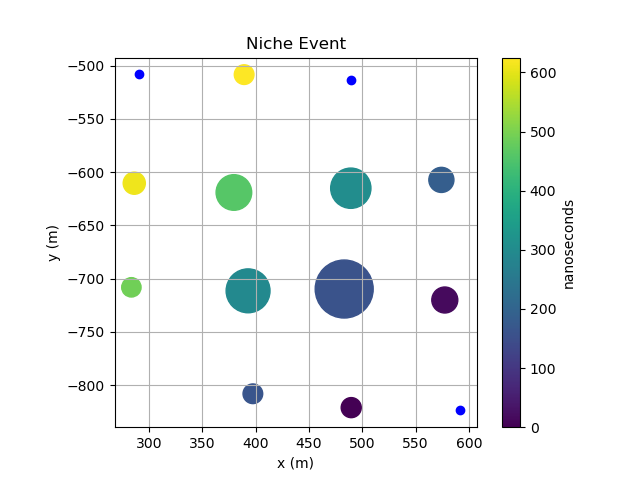

In [15]:
fit_nfits = pe.gen_nfits_from_event(fit_ev)
plot_event(tyro(fit_nfits))

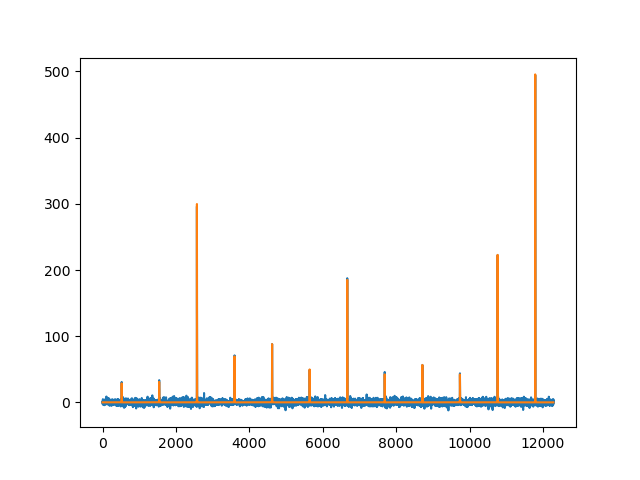

In [16]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.plot(at.real_values)
plt.plot(at.get_output(pars))

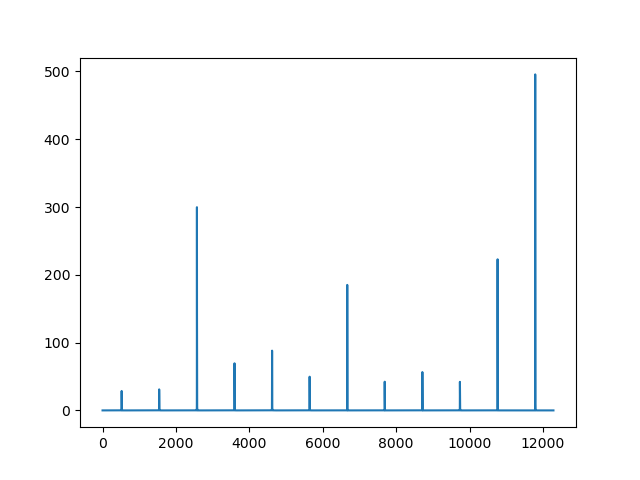

In [17]:
plt.figure()
plt.plot(at.get_output(pars))

In [18]:
at.chi2(pars)/m.ndof

1.0062721965491173

In [19]:
m._fcn(pars)/m.ndof

1.0062721965491208

In [20]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.272e+04 (χ²/ndof = 1.0)  │             Nfcn = 2788              │
│ EDM = 9.34e+05 (Goal: 0.01)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax    │ 504.9812  │  0.0028   │  -0.0131   │   0.0131   │   300   │   600   │       │
│ 1 │ nmax    │ 1.97491e6 │ 0.00006e6 │ -0.00413e6 │ 0.00413e6  │ 100000  │  1e+07  │       │
│ 2 │ zenith  │697.830e-3 │ 0.009e-3  │ -0.008e-3  │  0.008e-3  │0.653899 │0.853899 │       │
│ 3 │ azimuth │ 5.500869  │ 0.054448  │ -0.000032  │  0.000032  │ 5.36695 │ 5.56695 │       │
│ 4 │ corex   │ 448.4941  │  0.0023   │  -0.0021   │   0.0021   │  379.5  │  489.2  │       │
│ 5 │ corey   │-658.20519 │  0.00014  │  -0.00127  │  0.00127   │ -711.4  │ -615.1  │       │
│ 6 │ corez   │   -25.7   │    1.0    │            │            │-26.6841 │-24.6841 │  yes  │
│ 7 │ x0      │     0     │     1     │            │            │  -100   │   100   │  yes  │
│ 8 │ lambda  │    70     │     1     │            │            │    0    │   100   │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         xmax          │         nmax          │        zenith         │        azimuth        │         corex         │         corey         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.013   │   0.013   │   -4e3    │    4e3    │   -8e-6   │   8e-6    │ -0.032e-3 │ 0.032e-3  │  -0.0021  │  0.0021   │  -0.0013  │  0.0013   │
│  Valid   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   True    │   True    │   True    │   False   │   True    │   True    │   True    │   False   │   True    │   False   │   True    │   True    │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │         xmax         nmax       zenith      azimuth        corex        corey        corez           x0       lambda │
├─────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    xmax │      7.7e-06     2.410e-3     -2.07e-9       -13

In [21]:
m.errordef

1.0